# PRACTICA DE MACHINE LEARNING: HUNDIMIENTO DEL TITANIC

### Introducción
El hundimiento del Titanic es sin duda algua una de las tragedias más famosas del mundo. El 15 de abril de 1912, el Titanic, que se creía insumergible, chocó con un iceberg durante su viaje de inauguración. El desastre resultó en la muerte de 1502 de los 2224 pasajeros y tripulantes a bordo, datos muy agravados debido a la falta de botes salvavidas a bordo.

Esta práctica tiene los siguientes objetivos:
1. Entrenar a un conjunto de predictores y comparar su rendimiento. Estos predictores serán la regresión logística, perceptrón y árboles de decisión, con los procesos de análisis de datos, entrenamiento y
extracción de resultados.
2. Obtener y analizar la importancia de cada característica de los tripulantes por cada uno de los modelos entrenados.

## 1. Análisis exploratorio de datos
En esta parte se realizará un análisis de los datos para conocerlos y en el caso de que haya falta limpiarlos de "datos sucios". Después de analizarlos, se entrenarán con diferentes modelos para predecir si un pasajero sobrevivirá o no. Y por último se compararán los resultados de los modelos y se llevarán a cabo conclusiones.

In [1]:
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings as wrn
import seaborn as sns

### Carga de dataset

In [2]:
df = pd.read_csv("./dades.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Las características de los datos son las siguientes:
- **Survived**: 0 = No, 1 = Sí
- **Pclass**: Clase de ticket 1 = 1st, 2 = 2nd, 3 = 3rd
- **Name**: Nombre de la persona pasajera
- **Sex**: Hombre o mujer
- **Age**: Edad en años
- **SibSp**: # de hermanos / esposos a bordo del Titanic
- **Parch**: # de padres / hijos a bordo del Titanic
- **Ticket**: Número de ticket
- **Fare**: Tarifa de pasajero
- **Cabin**: Número de cabina
- **Embarked**: Puerto de embarque C = Cherbourg, Q = Queenstown, S = Southampton

### Eliminación de características no relevantes

El nombre de los pasajeros obviamente no afecta de ninguna forma a su probabilidad de sobrevibir, al igual que su número de tiquet, el cual es un string aleatorio. Por lo tanto, estas dos columnas se pueden eliminar sin problemas.

Lo mismo ocurre con el ID del pasajero, es un número asignado aleatoriamente y por lo tanto no nos aporta ninguna información sobre el pasajero.

In [3]:
df.drop("PassengerId", axis=1, inplace=True)
df.drop("Name", axis=1, inplace=True)
df.drop("Ticket", axis=1, inplace=True)

### Rellenado de valores nulos

A continuación se pasa a comprobar cuantos datos faltan de cada columna en el dataset para rellenarlos con valores que los modelos puedan utilizar:

In [4]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Como se puede observar faltan bastantes datos de la columna `Age` y `Cabin`.

- Para la columna `Age` se va a rellenar con la media de la edad de los pasajeros.
- Para la columna `Embarked`, se va a rellenar con la moda, el valor más común, ya que la media no existe para valores de tipo `string`
- Por último a la columna `Cabin` se le va a realizar una transformación más significativa: Se ignorará el identificador exacto de la cabina y se pasará a considerar únicamente si el pasajero tiene cabina (valor `1`) o no (valor `0`). Esto se hará así ya que si usaramos *one-hot encoding* (Ver sección [Transformación de características en valores numéricos](#transformación-de-características-en-valores-numéricos)), el dataset tendría demasiadas columnas y no sería práctico. Para no confundir el significado de este nuevo valor con el anterior de `Cabin` se sustituirá por una nueva columna: `HasCabin`.

In [5]:
df["Age"].fillna(df["Age"].mean(), inplace=True)
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
df["HasCabin"] = df.pop("Cabin").apply(lambda x: 0 if pd.isnull(x) else 1)

df.isnull().sum()


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
HasCabin    0
dtype: int64

### Transformación de características en valores numéricos

Es imposible utilizar las características `Sex` y `Embarked` en su estado actual, ya que los modelos que se utilizarán solo aceptan valores numéricos y estas tres características tienen valores de tipo `string`.

Para convertir estos valores a números, se podrían seguir dos métodos:
- Asignar un valor de 0 a N, a cada valor posible de la característica, siendo N el recuento total de todas las variantes posibles.
- Utilizar *one-hot encoding*, que consiste en crear N columnas nuevas, una por cada variante de la característica, y asignar 0 a todas las nuevas columnas excepto a la correspondiente al valor real de la característica para ese individuo. Así, `Embarked=S` se convertiría en `Embarked_C=1, Embarked_Q=0, Embarked_S=0`.

Si bien existen estos dos métodos, aplicar el primero no sería apropiado, ya que tanto `Sex` como `Embarked` son características categóricas, y al asignarle números a cada variante, estaríamos dotando a esas variantes de un orden que no tenían previamente, cosa que afectará al modelo resultante. Utilizar *one-hot encoding* permite transformar los valores para que puedan ser utilizados sin necesidad de darles un orden entre ellos.

In [6]:
columns_to_transform = ["Sex", "Embarked"]

columns = df.loc[:, columns_to_transform]
df.drop(columns, axis=1, inplace=True)

ohe = pd.get_dummies(columns, columns=columns_to_transform, prefix=columns_to_transform)
df = pd.concat(
    [df.reset_index(drop=True), ohe.reset_index(drop=True)], axis=1, sort=False
)

df.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,1,0,0,1


### Correlación de características con `Survived`


A continuación se muestra la correlación de cada característica del data set con la columna `Survived`:

In [7]:
corr = df.corr()["Survived"].sort_values(ascending=False)
corr

Survived      1.000000
Sex_female    0.543351
HasCabin      0.316912
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.149683
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64

Después de realizar el análisis de las características, se puede observar que la característica `Sex` es la que más correlación tiene con la supervivencia, que con los datos obtenidos al ser una mujer, aumenta la probabilidad de sobrevivir, y al ser hombre, disminuye en la misma magnitud. También las características de `Pclass` y `HasCabin` tienen una correlación alta con la supervivencia, por lo que se puede concluir que la clase social y si el pasajero tiene cabina también afecta a la supervivencia, con los que los pasajeros de primera clase y con cabina tenían más posibilidades de sobrevivir. Respecto a la característica `Age`, se puede observar que los niños tienen más probabilidades de sobrevivir que los adultos, y que los las personas mayores tienen menos probabilidades de sobrevivir que los jóvenes. La característica `Embarked` no tiene una correlación muy alta con la supervivencia, pero un dato curioso es que los pasajeros que embarcaron en Cherbourg tienen más probabilidades de sobrevivir que los que embarcaron en Southampton o Queenstown.

En este punto, se hace un pensamiento para mirar si se pueden quitar características que no aporten nada al modelo, por lo que si solo nos quedamos con las características que tienen una correlación mayor a 0.1 con la supervivencia, se obtiene el siguiente resultado:

In [8]:
corr.loc[abs(corr) > 0.1]

Survived      1.000000
Sex_female    0.543351
HasCabin      0.316912
Fare          0.257307
Embarked_C    0.168240
Embarked_S   -0.149683
Pclass       -0.338481
Sex_male     -0.543351
Name: Survived, dtype: float64

Si solo nos quedamos con las características que tienen una correlación mayor a 0.1 con la supervivencia, el modelo tan solo se quedaría con 7 características, lo que es un número muy bajo para un modelo de clasificación. Por lo tanto, se van a utilizar todas las características.

### Entrenamiento de modelos

Se hará una copia del dataframe limpio para poder usarlo en el siguiente apartado sin que sea afectado por las modificaciones que se puedan hacer para facilitar el entrenamiento en este apartado

In [9]:
data = df.copy()

Se elimina la columna `Survived` del dataframe para poder entrenar los modelos con el resto de características. Después se divide el dataset en dos, uno para entrenar los modelos y otro para testearlos.

También se normaliza el dataset, lo que significa que todos los valores de una columna son mapeados a valores proporcionales entre `0` y `1`. Esto es imprescindible para encontrar la *feature importance* ya que sin esta normalización, los coeficientes no serían proporcionales los unos a los otros (i.e. un coeficiente el doble de grande no significaría que es el doble de importante) y por ende no se podrían interpretar correctamente.

In [10]:
label = data.pop("Survived")

# Normalización del dataset
data = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(data), columns=data.columns
)

display(data)

RANDOM_STATE = 42
x_train, x_test, y_train, y_test = train_test_split(
    data, label, test_size=0.33, random_state=RANDOM_STATE
)

,Pclass,Age,SibSp,Parch,Fare,HasCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.271174,0.125,0.000000,0.014151,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.472229,0.125,0.000000,0.139136,1.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.321438,0.000,0.000000,0.015469,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.434531,0.125,0.000000,0.103644,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.434531,0.000,0.000000,0.015713,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0.5,0.334004,0.000,0.000000,0.025374,0.0,0.0,1.0,0.0,0.0,1.0
887,0.0,0.233476,0.000,0.000000,0.058556,1.0,1.0,0.0,0.0,0.0,1.0
888,1.0,0.367921,0.125,0.333333,0.045771,0.0,1.0,0.0,0.0,0.0,1.0
889,0.0,0.321438,0.000,0.000000,0.058556,1.0,0.0,1.0,1.0,0.0,0.0


Por último, se van a entrenar varios modelos de clasificación para ver cuál de ellos tiene mejor rendimiento y antes se realizará una búsqueda de hiperparámetros para cada modelo para ver si se puede mejorar el rendimiento de los siguientes modelos:

#### Regresión Logística

Los parámetros que se van a probar son:
- `C`: Para la regularización del modelo. Los valores más pequeños especifican una regularización más fuerte.
- `solver`: Algoritmo para ajustar el modelo. Se probarán los siguientes:
    - `newton-cg`: Algoritmo de Newton-CG. Este algoritmo suele ser eficiente para modelos pequeños o medios. Suele ser más eficiente que `lbfgs` para modelos grandes y se recomienda cuando el número de características es mayor que el número de muestras.
    - `lbfgs`: Algoritmo de L-BFGS. Este algoritmo suele ser eficiente para modelos pequeños o medios y se recomienda cuando el número de características es mayor que el número de muestras.
    - `liblinear`: Algoritmo de descenso de gradiente estocástico. Este algoritmo es más eficiente para modelos con un gran número de muestras y se recomienda cuando el número de características es menor que el número de muestras.
    - `sag`: Es un algoritmo de optimización que utiliza una variante del SGD con memoria. Se utiliza cuando el número de características es mayor que el número de muestras.
    - `saga`: Algoritmo de descenso de gradiente estocástico con memoria. Se utiliza cuando el número de características es mayor que el número de muestras.
- `penalty`: Especifica la norma de la penalización:
    - `none`: No se aplica penalización.
    - `l1`: Norma L1. Este término se calcula como la suma absoluta de los pesos de las características y se multiplica por un factor de regularización (lambda).
    - `l2`: Norma L2. Este término se calcula como la suma de los cuadrados de los pesos de las características y se multiplica por un factor de regularización (lambda).
    - `elasticnet`: Se utiliza una combinación de norma L1 y L2.

In [11]:
wrn.filterwarnings("ignore")  # Ignorar warnings

param_grid = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "penalty": ["none", "elasticnet", "l1", "l2"],
}

clf = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    param_grid,
    n_jobs=-1,
    scoring="accuracy",
)

logistic_fit = clf.fit(x_train, y_train)

print(f"Hiperparámetros óptimos:\n{clf.best_params_}")

logistic_pred = clf.predict(x_test)
print(f"Métricas:\n{classification_report(y_test, logistic_pred)}")


Hiperparámetros óptimos:
{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}
Métricas:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       175
           1       0.81      0.73      0.77       120

    accuracy                           0.82       295
   macro avg       0.82      0.81      0.81       295
weighted avg       0.82      0.82      0.82       295



#### Perceptron

Los parámetros que se van a probar son:
- `alpha`: Es el parámetro de regularización utilizado para evitar el sobreajuste del modelo. Un valor mayor de alpha significa una mayor penalización de los pesos del modelo y un modelo más simple.
- `penalty`: Igual que en la regresión logística.
- `fit_intercept`: Indica si se debe ajustar un término independiente (intercepto) en el modelo o no.
- `tol`: Es el umbral de tolerancia para el error. Si el error es menor que tol, se detiene el entrenamiento del modelo.
- `max_iter`: Es el número máximo de iteraciones permitidas para el ajuste del modelo. Si se alcanza el número máximo de iteraciones sin converger, el modelo se detiene y se genera una excepción.
- `eta0`: Es el tamaño de paso utilizado por el modelo para actualizar los pesos en cada iteración. Un valor mayor de eta0 significa una mayor actualización de los pesos en cada iteración, lo que puede conducir a una mayor convergencia del modelo pero también puede aumentar el riesgo de divergencia.

In [12]:
param_grid = {
    "alpha": [0.000001, 0.0001, 0.001, 0.01, 0.1],
    "penalty": [None, "elasticnet", "l1", "l2"],
    "fit_intercept": [True, False],
    "tol": [1e-3, 1e-4, 1e-5, 1e-6],
    "max_iter": [10, 20, 50, 100, 1000, 2500, 5000],
    "eta0": [0.001, 0.01, 0.1, 1, 10]
}

clf = GridSearchCV(
    Perceptron(random_state=RANDOM_STATE), param_grid, n_jobs=-1, scoring="accuracy"
)
perceptron_fit = clf.fit(x_train, y_train)
print(f"Hiperparámetros óptimos:\n{clf.best_params_}\n")

perceptron_pred = clf.predict(x_test)
print(f"Métricas:\n{classification_report(y_test, perceptron_pred)}")


Hiperparámetros óptimos:
{'alpha': 0.1, 'eta0': 0.01, 'fit_intercept': False, 'max_iter': 20, 'penalty': 'elasticnet', 'tol': 1e-06}

Métricas:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       175
           1       0.78      0.70      0.74       120

    accuracy                           0.80       295
   macro avg       0.79      0.78      0.79       295
weighted avg       0.80      0.80      0.79       295



#### Árbol de Decisión

Los parámetros que se van a probar son:
-
- `max_features`: Es el número máximo de características que se consideran al buscar la mejor división. Si se especifica `None`, se consideran todas las características. `max_depth`: Es la profundidad máxima del árbol. Si se especifica `None`, el árbol se expande hasta que todas las hojas son puras o hasta que todas las hojas contienen menos de `min_samples_split` muestras.
- criterion`: Es la función de medida de calidad que se utiliza para dividir los nodos. Se probarán las siguientes:
    - `gini`: Para calcular la pureza del nodo utilizando el índice Gini.
    - `entropy`: Para calcular la pureza del nodo utilizando utilizando la entropía.

Hiperparámetros óptimos:
{'criterion': 'entropy', 'max_depth': 6, 'max_features': None}

Métricas:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       175
           1       0.77      0.63      0.69       120

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.76       295
weighted avg       0.77      0.77      0.77       295


Visualización del Árbol


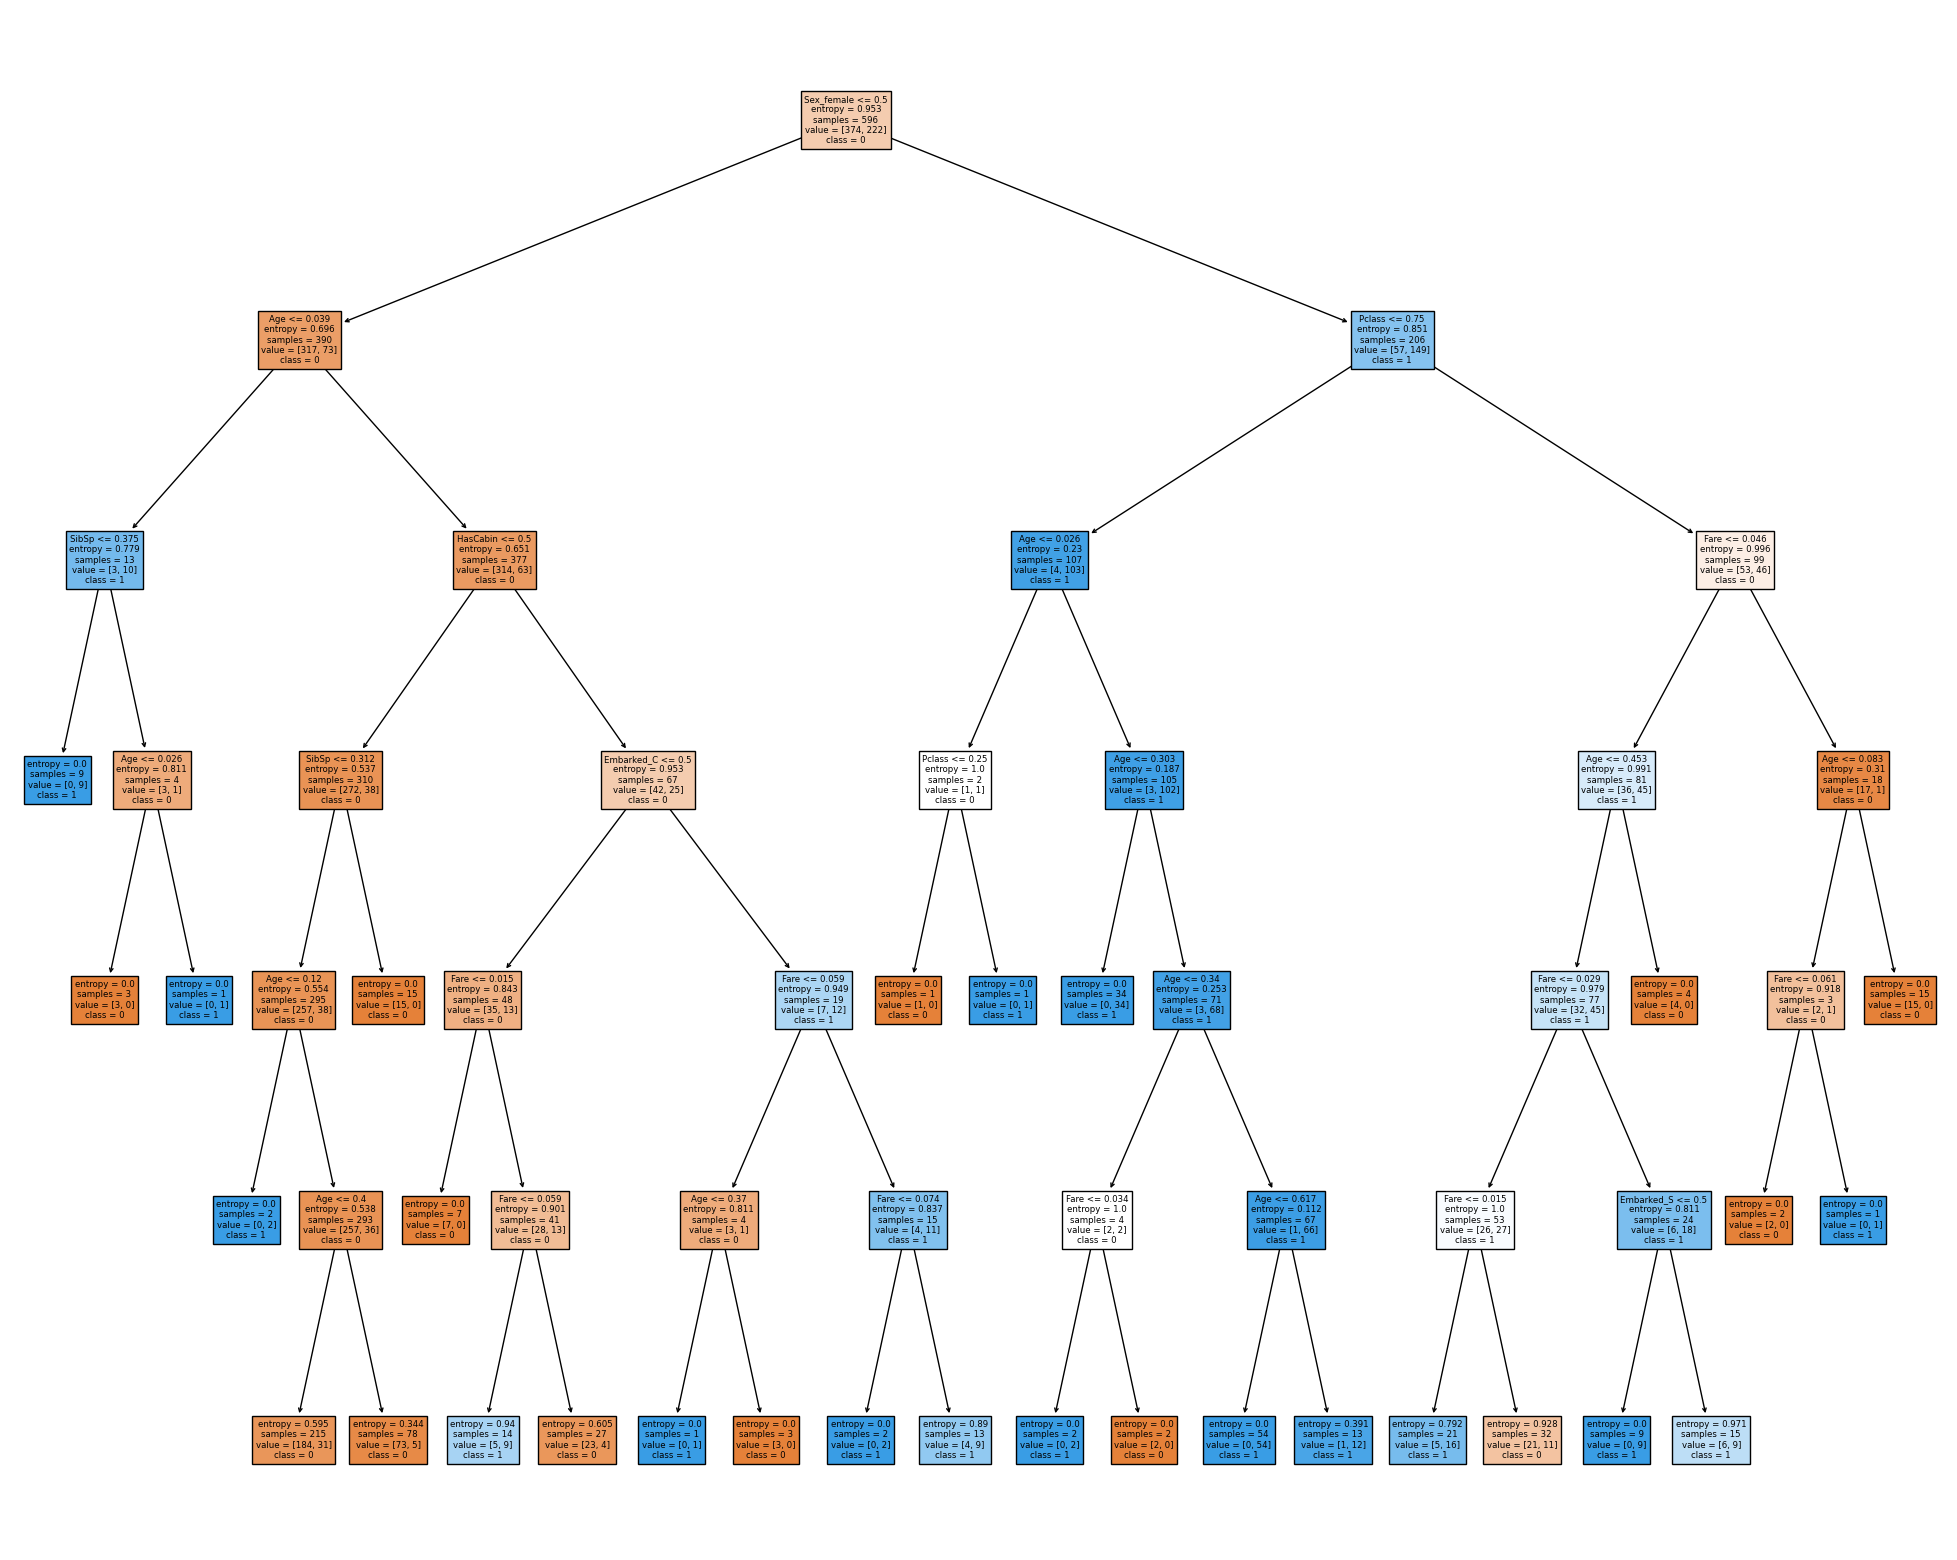

In [13]:
param_grid = {
    "max_features": [None, "sqrt", "log2"],
    "max_depth": [None, 24, 6, 8, 10, 12],
    "criterion": ["gini", "entropy"]
}

clf = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid,
    n_jobs=-1,
    scoring="accuracy",
)
dt_fit = clf.fit(x_train, y_train)
print(f"Hiperparámetros óptimos:\n{clf.best_params_}\n")

dt_pred = clf.predict(x_test)
print(f"Métricas:\n{classification_report(y_test, dt_pred)}\n")

print("Visualización del Árbol")
plt.figure(figsize=(25, 20))
_ = plot_tree(
    clf.best_estimator_, feature_names=data.columns, class_names=["0", "1"], filled=True
)


#### Random Forest

Los parámetros que se van a probar son:
- `n_estimators`: Es el número de árboles que se van a construir.
- `max_depth`: Lo mismo que en el árbol de decisión.
- `max_features`: Lo mismo que en el árbol de decisión.
- `criterion`: Lo mismo que en el árbol de decisión.

Hiperparámetros óptimos:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

Métricas:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       175
           1       0.84      0.68      0.75       120

    accuracy                           0.82       295
   macro avg       0.82      0.80      0.80       295
weighted avg       0.82      0.82      0.81       295


Visualización de uno de los Árboles


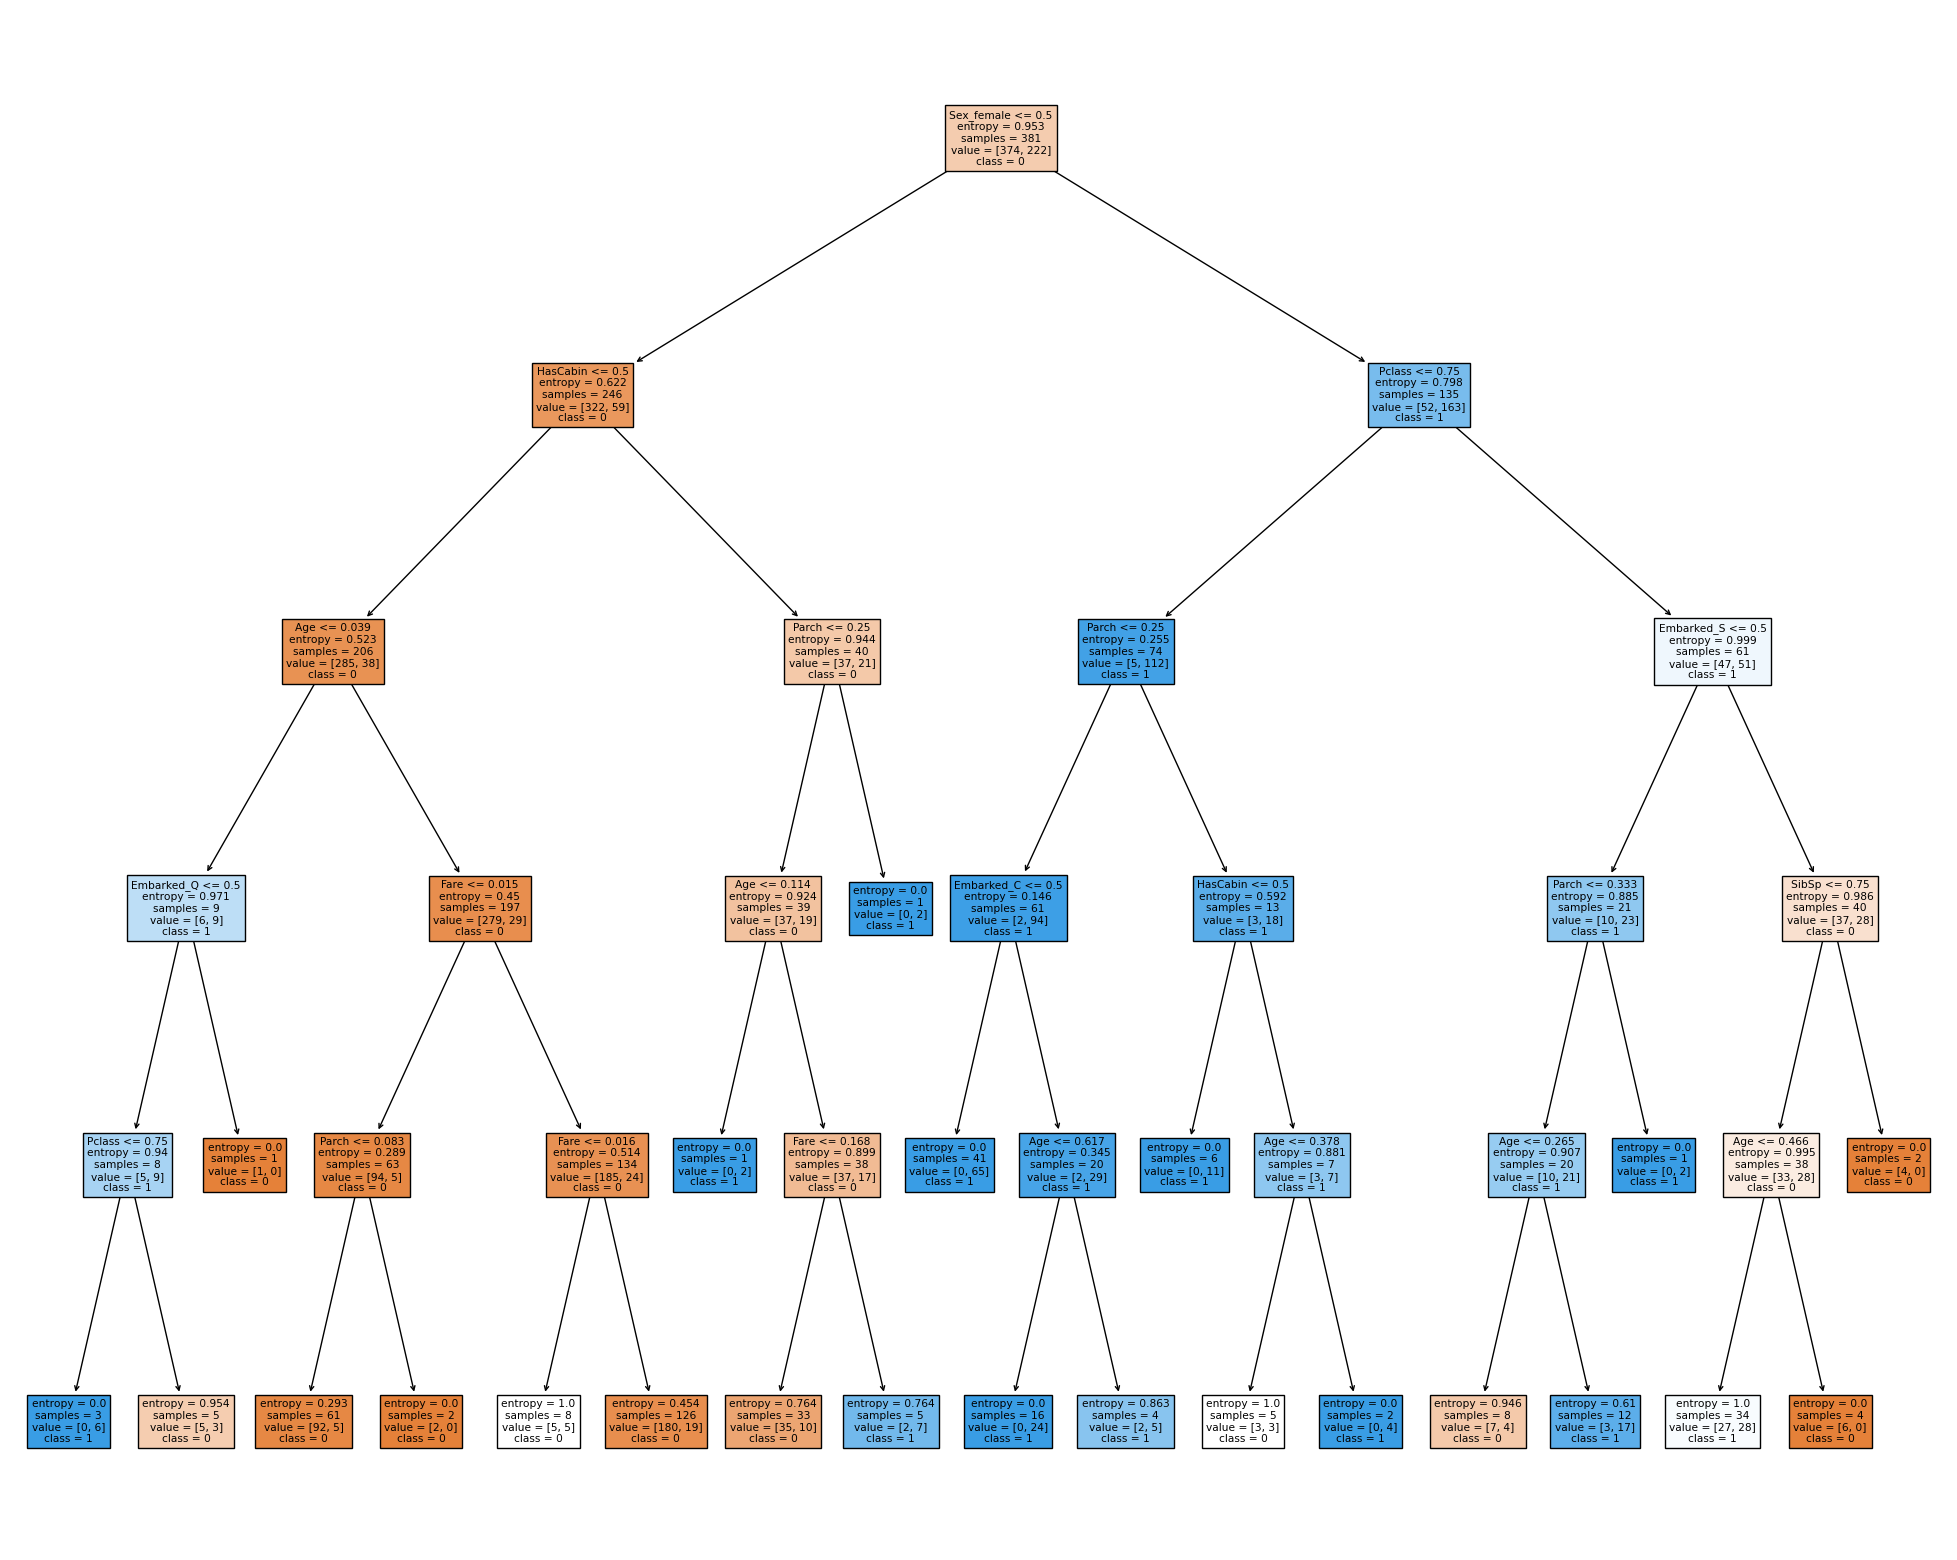

In [14]:
param_grid = {
    "n_estimators": [10, 20, 50, 100, 150, 200, 250],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 2, 3, 4, 5],
    "criterion": ["gini", "entropy"]
}

clf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid,
    n_jobs=-1,
    scoring="accuracy",
)

rf_fit = clf.fit(x_train, y_train)
print(f"Hiperparámetros óptimos:\n{clf.best_params_}\n")

rf_pred = clf.predict(x_test)
print(f"Métricas:\n{classification_report(y_test, rf_pred)}\n")

print("Visualización de uno de los Árboles")
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(
    clf.best_estimator_.estimators_[0],
    feature_names=data.columns,
    class_names=["0", "1"],
    filled=True,
)


### Análisis de resultados

A continuación, se compilarán todos los informes de los clasificadores para poder sacar conclusiones sobre su funcionamiento más fácilmente. Para cada predicción de los modelos, se generará un dataframe que contenga el nombre del modelo y una métrica, para posteriormente ordenar los elementos y generar una clasificación de los mejores modelos para cada métrica.

In [15]:
# Dataframe base. Se mapeará la columna "Predictions" para generar los distintos dataframes finales
base_df = pd.DataFrame.from_dict(
    {
        "Name": [
            "Regresión Logística",
            "Perceptrón",
            "Árbol de Decisión",
            "Random Forest",
        ],
        "Predictions": [logistic_pred, perceptron_pred, dt_pred, rf_pred],
    }
)


def create_score_df(scorer, **kwargs):
    df = base_df.copy()
    df["Score"] = df.pop("Predictions").map(lambda pred: scorer(y_test, pred, **kwargs))
    df = df.sort_values(by="Score", ascending=False).reset_index(drop=True).round(2)

    return df


def display_multiple_dfs(df_captions, df_list):
    result = ""

    for caption, df in zip(df_captions, df_list):
        result += (
            df.style.set_table_attributes(
                "style='display:inline-block; margin-right: 30px;'"
            )
            .set_caption(caption)
            ._repr_html_()
        )

    display(HTML(result))


display_multiple_dfs(
    ["Accuracy", "Precision", "Recall", "F1"],
    [
        create_score_df(accuracy_score),
        create_score_df(precision_score, average="weighted"),
        create_score_df(recall_score, average="weighted"),
        create_score_df(f1_score, average="weighted"),
    ],
)


,Name,Score
0,Regresión Logística,0.820000
1,Random Forest,0.820000
2,Perceptrón,0.800000
3,Árbol de Decisión,0.770000
,Name,Score
0,Regresión Logística,0.820000
1,Random Forest,0.820000
2,Perceptrón,0.800000
3,Árbol de Decisión,0.770000
,Name,Score


Se puede observar que el orden de los modelos se mantiene idéntico entre las diferentes tablas. Los peores modelos son sin duda el Perceptrón y el Árbol de decisión simple. El mejor es la Regresión logística, aunque muy empatado con el Random forest, que solo tiene una `F1-score` inferior en `0.01`.

## 2. _Feature Importance_

A continuación se va a analizar la importancia de cada una de las características para cada modelo y así poder determinar cuáles son las más importantes para cada modelo, a la vez de su imfluencia en el resultado final. En el caso de que se tuviera un dataset con muchas características, se podría eliminar aquellas que tuvieran una importancia baja y así reducir el tiempo de entrenamiento y el espacio de almacenamiento.

In [16]:
def plot_importance(importance_list, ax):
    importance_table = pd.Series(importance_list, index=data.columns).sort_values()

    importance_table.plot(
        kind="barh", align="center", color=sns.color_palette("hls", len(importance_table)), ax=ax
    )

    plt.tight_layout(pad=5)
    ax.set_xlabel("Importancia")
    ax.set_ylabel("Característica")
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

    return importance_table

def plot_coeficients_as_importance(coef):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title("Importancia absoluta")
    plot_importance(abs(coef), ax1)

    ax2.set_title("Importancia signada\n(valores negativos significan relaciones inversamente proporcionales)")
    plot_importance(coef, ax2)

### Regresión Logística


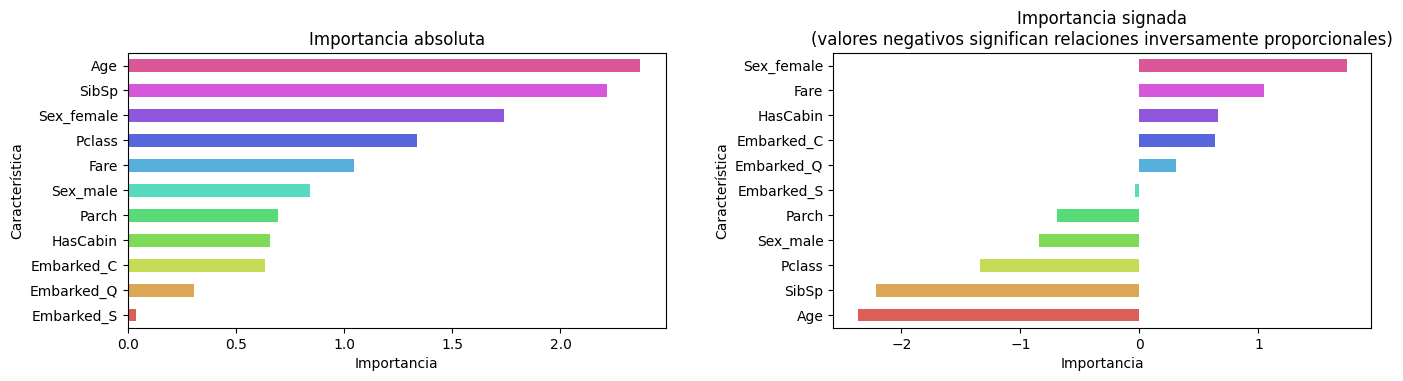

In [17]:
plot_coeficients_as_importance(logistic_fit.best_estimator_.coef_[0])
plt.show()

Observando la tabla anterior, se pueden sacar las siguientes conclusiones:
- La característica más importante para la Regresión logística es `Age`, pero con un valor negativo. Esto significa que cuanto mayor es la edad, menor es la probabilidad de que el pasajero sobreviva (relación inversamente proporcional).
- El número de hermanos o cónyuges a bordo (`SibSp`) es la segunda característica más importante, seguida de la edad (`Age`), también con un valor negativo. Esto significa que cuanto mayor es el número de hermanos o cónyuges a bordo, menor es la probabilidad de que el pasajero sobreviva.
- La clase del pasajero (`Pclass`) es la cuarta característica más importante con un valor negativo. Esto significa que cuanto mayor es la clase del pasajero, menor es la probabilidad de que el pasajero sobreviva.
- Respecto al sexo: 
    - El sexo femeneino (`Sex_female`), es la tercera característica más importante con un valor positivo. Esto significa que el sexo femeneino aumenta la probabilidad de que el pasajero sobreviva.
    - El sexo masculino (`Sex_male`), es la sexta característica más importante con un valor negativo. Esto significa que el sexo masculino disminuye la probabilidad de que el pasajero sobreviva.
- La clase del pasajero (`Pclass`) es la cuarta característica más importante con un valor negativo. Esto significa que cuanto mayor es la clase del pasajero, menor es la probabilidad de que el pasajero sobreviva.
- La tarifa pagada (`Fare`) es la quinta característica más importante con un valor positivo. Esto significa que cuanto mayor es la tarifa pagada, mayor es la probabilidad de que el pasajero sobreviva.
- El numero de padres o hijos a bordo (`Parch`) es la septima característica más importante con un valor negativo. Lo que significa que los pasajeros que viajaban solos o con una de los padres u hijos tuvieron más probabilidades de sobrevivir.
- Si el pasajero tenía cabina (`HasCabin`) es la octava característica más importante con un valor positivo. Esto significa que los pasajeros que tenían cabina tuvieron más probabilidades de sobrevivir.
- Por último, el puerto de embarque (`Embarked`) son las características menos importantes, ya que no influyen en el resultado final. Pero los pasajeros que embarcaron en el puerto de Cherbourg (`Embarked_C`) tuvieron más probabilidades de sobrevivir, seguido de los que embarcaron en el puerto de Queenstown (`Embarked_Q`) y por último los que embarcaron en el puerto de Southampton (`Embarked_S`).

#### Perceptron

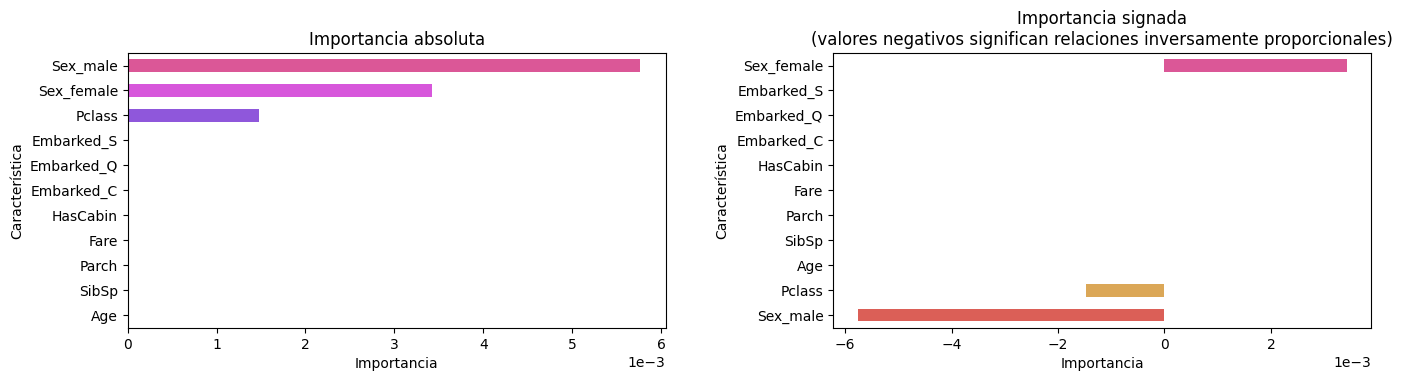

In [18]:
plot_coeficients_as_importance(perceptron_fit.best_estimator_.coef_[0])
plt.show()

Los datos de importancia del perceptrón sugieren básicamente lo mismo que los de la regresión, pero destaca una diferencia clara: solo hay tres características que tengan coeficientes no nulos. Esto indica que el mejor perceptrón posible (dentro de nuestros límites especificados), el que mejor funciona es aquel que ignora todas las características salvo 3, lo cual es muy interesante.

#### Árbol de decisión

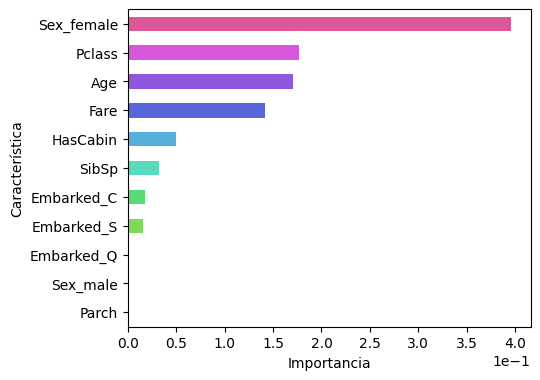

In [19]:
_, ax = plt.subplots(1, 1)
plot_importance(dt_fit.best_estimator_.feature_importances_, ax)
plt.show()

Respecto a las características más importantes del modelo de árbol de decisión, se puede observar que una de las características más importantes es el sexo, concretamente el sexo femenino. Esto significa que el sexo femenino aumenta la probabilidad de que el pasajero sobreviva. También se puede observar que la clase del pasajero es la segunda característica más importante, seguida de la edad y la tarifa pagada.

Una vez más, es interesante observar cómo el mejor árbol de decisión que el `GridSearchCV` ha encontrado ignora 3 de las características.

#### Random Forest

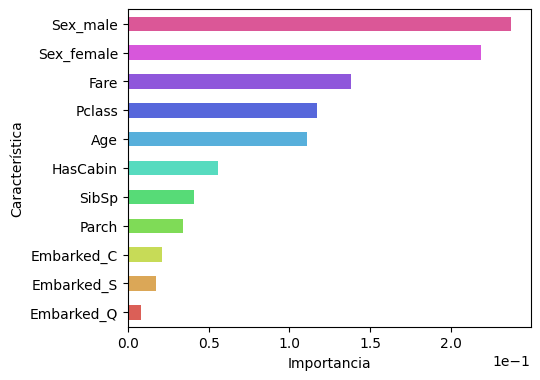

In [20]:
_, ax = plt.subplots(1, 1)
plot_importance(rf_fit.best_estimator_.feature_importances_, ax)
plt.show()

Por último, el modelo de Random Forest, vuelve a destacar el sexo femenino como la característica más importante, seguida de la clase del pasajero, la edad y la tarifa pagada. Esto significa que el sexo femenino aumenta la probabilidad de que el pasajero sobreviva, seguido de la clase del pasajero, la edad y la tarifa pagada.

#### Referencias
* [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)
* [Titanic Data Science Solutions](https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy/notebook)
* [Documentación de Scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn)